In [114]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [115]:
EMISSION_FACTORS = {
    "Dual Fuel": 0.444,
    "Natural Gas": 0.426,
    "Nuclear": 0,
    "Other Fossil Fuels": 0.935,
    "Other Renewables": 0.256,
    "Wind": 0,
    "Hydro": 0
}
REPOSITORY_NAME = '20190801rtfuelmix_csv'

In [116]:
def process_average(row) -> any:
    if row[3] != 0:
        row["co2"] = EMISSION_FACTORS[row["Fuel Category"]]/(row[3]/1000)
    else:
        row["co2"] = 0
    return row


def process_time_stamp(row) -> any:
    row["Time Stamp"] = row[0].split(" ")[1]
    return row

def process_date(row) -> any:
    row["Date"] = row[0].split(" ")[0]
    return row


def process_similarity(row) -> any:
    row["similarity_co2"] = abs(row["mean_co2"]["self"] - row["mean_co2"]["other"])
    row["similarity_mw"] = abs(row["mean_mw"]["self"] - row["mean_mw"]["other"])
    return row

In [121]:
file_names: list[str] = os.listdir(path=REPOSITORY_NAME)
data_buffer: list[pd.DataFrame] = list()


for file_name in file_names:
    file_path: str = f'{REPOSITORY_NAME}/{file_name}'
    read_csv_file: pd.DataFrame = pd.read_csv(filepath_or_buffer=file_path)
    read_csv_file = read_csv_file.apply(process_average, axis=1)
    read_csv_file = read_csv_file.apply(process_date, axis=1)
    read_csv_file = read_csv_file.apply(process_time_stamp, axis=1)
    data_buffer.append(read_csv_file)


In [122]:
data_mean_buffer: list[pd.DataFrame] = list()
data_time_stamp = pd.DataFrame()
data_time_stamp["Time Stamp"] = data_buffer[0].drop_duplicates(
    subset=["Time Stamp"], keep='first')["Time Stamp"]

for data in data_buffer:
    data_timpe_stamp_temp = data_time_stamp.copy()
    data_timpe_stamp_temp["mean_co2"] = data_timpe_stamp_temp["Time Stamp"].apply(
        lambda time: data.loc[data['Time Stamp'] == time]["co2"].mean())
    data_timpe_stamp_temp["mean_mw"] = data_timpe_stamp_temp["Time Stamp"].apply(
        lambda time: data.loc[data['Time Stamp'] == time]["Gen MW"].mean())
    data_timpe_stamp_temp["sum_mw"] = data_timpe_stamp_temp["Time Stamp"].apply(
        lambda time: data.loc[data['Time Stamp'] == time]["Gen MW"].sum())
    data_timpe_stamp_temp["date"] = data["Date"]
    # print(data_timpe_stamp_temp)
    data_mean_buffer.append(data_timpe_stamp_temp)


In [123]:
data_mean = pd.concat(data_mean_buffer)
# print(data_mean)
data_time_stamp_result = data_time_stamp.copy()


data_time_stamp_result["mean_co2"] = data_time_stamp_result["Time Stamp"].apply(
        lambda time: data_mean.loc[data_mean['Time Stamp'] == time]["mean_co2"].mean())
data_time_stamp_result["mean_mw"] = data_time_stamp_result["Time Stamp"].apply(
        lambda time: data_mean.loc[data_mean['Time Stamp'] == time]["mean_mw"].mean())

In [127]:
similarity = list()

for data in data_mean_buffer: 
    data = data[['Time Stamp', 'mean_co2','mean_mw']].copy()
    result = data_time_stamp_result.compare(data,align_axis=1,keep_shape=False,keep_equal=True)
    result = result.apply(process_similarity ,axis=1)
    mean_co2 = result["similarity_co2"].mean()
    mean_mw = result["similarity_mw"].mean()
    result_mean = (mean_co2 + mean_mw) / 2
    similarity.append(result_mean)
    # print(f"{result_mean}")

27


In [128]:
similarity_index = similarity.index(min(similarity))

<AxesSubplot:xlabel='Time Stamp'>

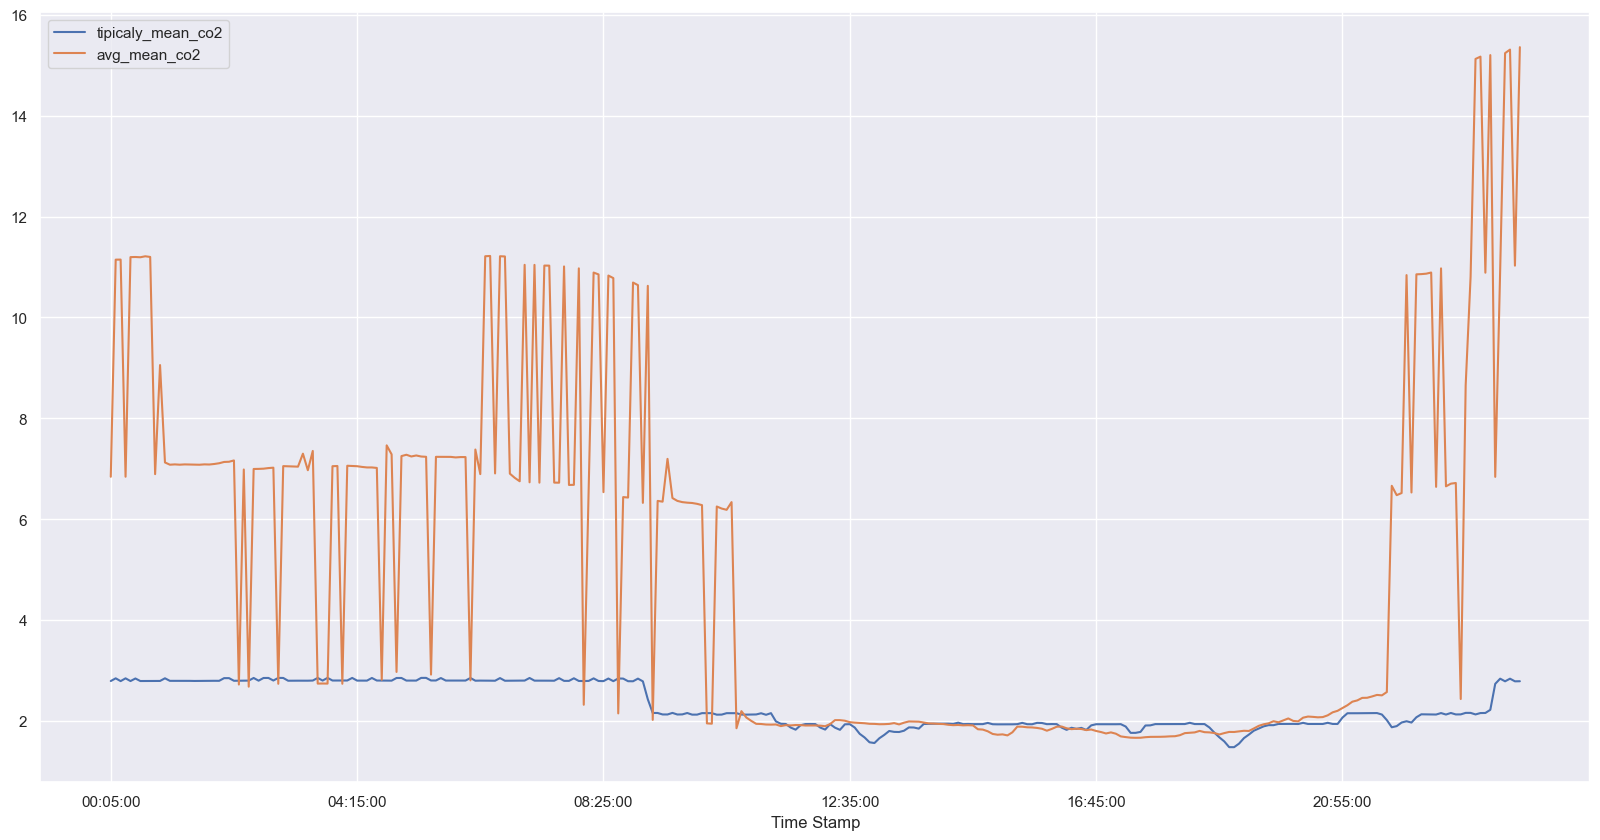

In [129]:
fig, ax = plt.subplots(figsize=(20,10)) 
data_mean_buffer[similarity_index].plot(x = 'Time Stamp', y = 'mean_co2', ax = ax, label="tipicaly_mean_co2") 
data_time_stamp_result.plot(x = 'Time Stamp', y = 'mean_co2', ax = ax, label="avg_mean_co2") 

<AxesSubplot:xlabel='Time Stamp'>

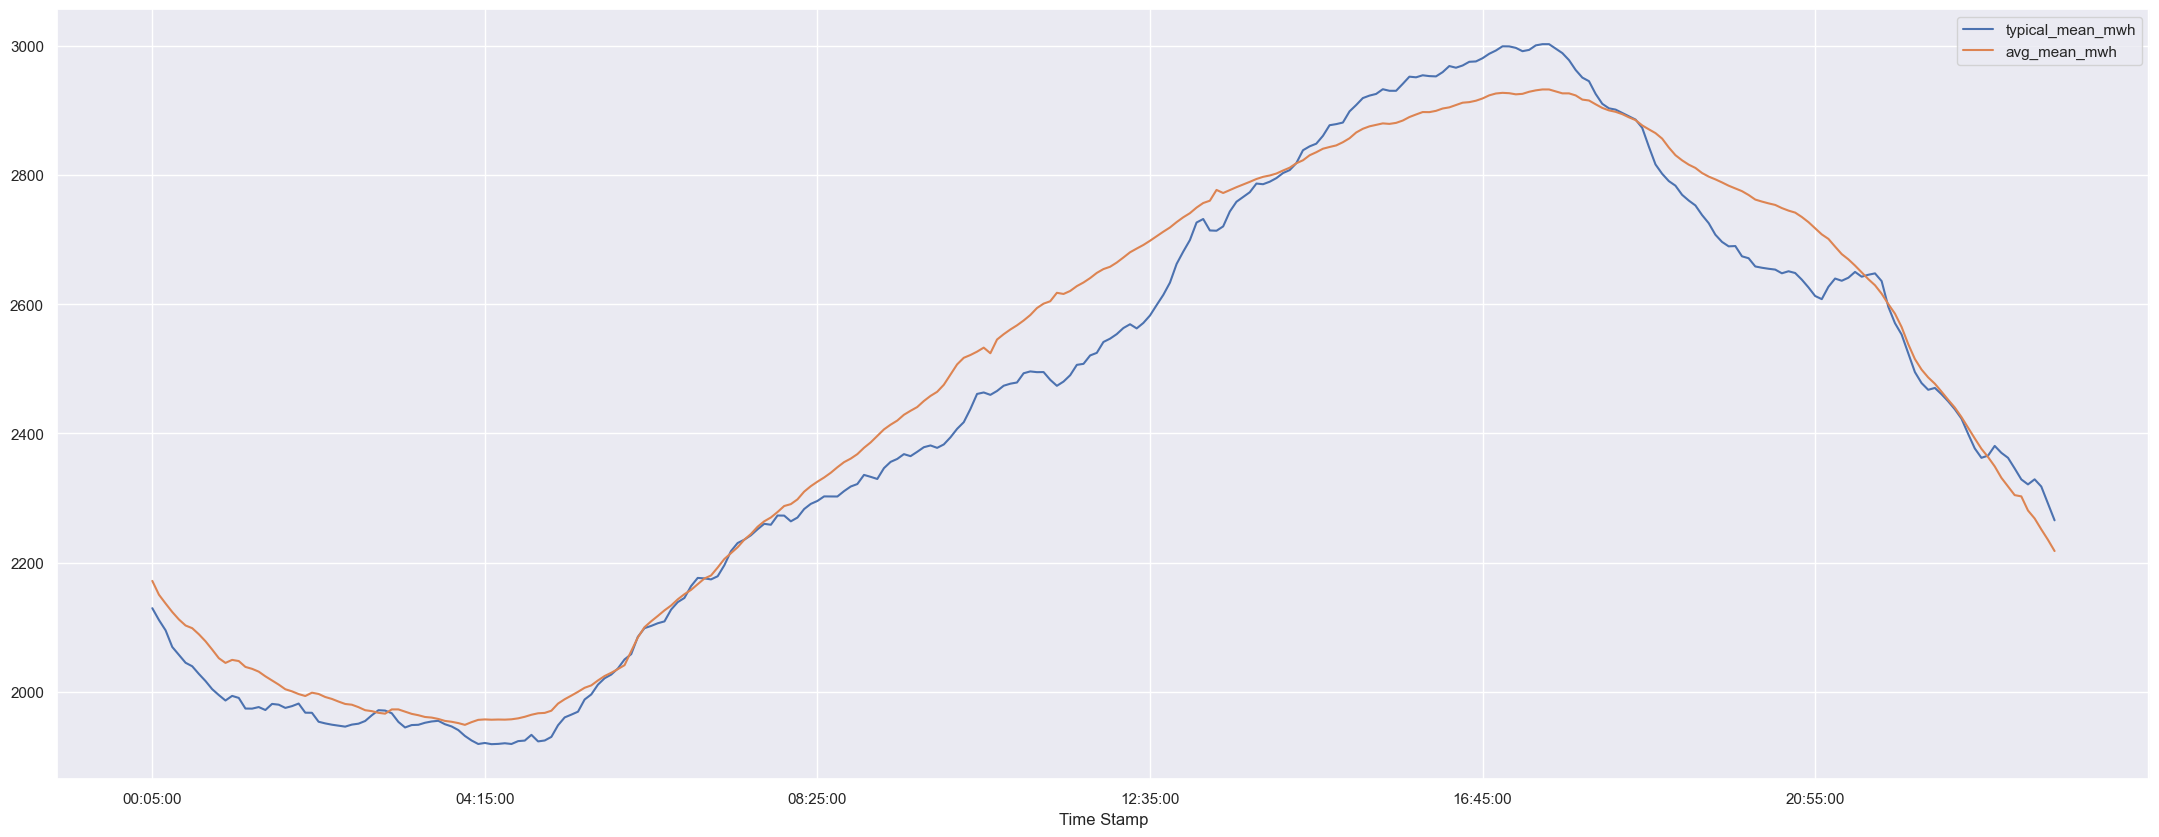

In [130]:
fig, ax = plt.subplots(figsize=(27,10)) 
data_mean_buffer[20].plot(x = 'Time Stamp', y = 'mean_mw',ax=ax,label="typical_mean_mwh") 
data_time_stamp_result.plot(x = 'Time Stamp', y = 'mean_mw', ax = ax, label="avg_mean_mwh") 

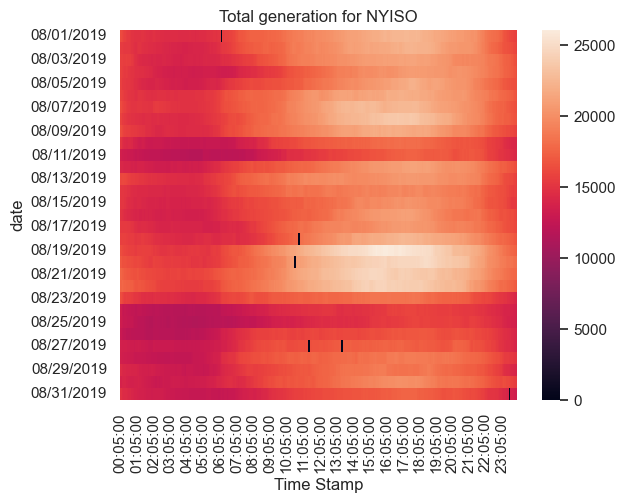

In [131]:
heat_map_data = data_mean.pivot("date", "Time Stamp", "sum_mw")
ax = sns.heatmap(heat_map_data)
plt.title("Total generation for NYISO")
plt.show()